In [67]:
#!/usr/bin/env python
"""
@author: Jayant Gupta
last update: 02.06.2021
"""

'\n@author: Jayant Gupta\nlast update: 02.06.2021\n'

In [68]:
# Import necessary libraries
import tensorflow as tf
import os
import random
import numpy as np

import models
 
from tqdm import tqdm 
import json

from skimage.io import imread, imshow, show
from skimage.transform import resize
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

# Handles reading large number of files.
Image.MAX_IMAGE_PIXELS = 219494175 

In [69]:
seed = 42
np.random.seed = seed

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4
IMG_INDEX = "ExG"

# This function creates a dictionary to store images and their mask.
# This function is curated to handle train images *.tif format and 
# mask file in *.jpeg format
def get_in_out_dict(Image_Path, Mask_Path, Index_Path=None, Index_Type=None):
    img_fns = os.listdir(Image_Path)
    mask_fns = os.listdir(Mask_Path)

    if IMG_CHANNELS > 3:
        indices_fns = os.listdir(Index_Path)

    in_out_dict = {}
    for img_filename in img_fns:
        key = img_filename.split('.')[0]
        in_out_dict[key] = []
        in_out_dict[key].append(
            os.path.join(Image_Path, img_filename))
        if IMG_CHANNELS > 3:
            in_out_dict[key].append(
                os.path.join(Index_Path, [index for index in indices_fns if key in index and Index_Type in index][0]))
        in_out_dict[key].append(
            os.path.join(Mask_Path, [mask for mask in mask_fns if key in mask][0]))
    
    for key in list(in_out_dict.keys())[0:5]:
        print(in_out_dict[key])

    return in_out_dict

# #train_mask_pair = {**train_mask_mpls_pair, **train_mask_stp_pair} # For OSFA
# #test_mask_pair = {**test_mask_mpls_pair, **test_mask_stp_pair}    # For OSFA 
Mask_Path = json.load(open('config.json'))['filepaths']['default_mask_folder']
Image_Path = json.load(open('config.json'))['filepaths']['input_imagery_dir']
in_out_dict = {}
if IMG_CHANNELS > 3:
    Index_Path = json.load(open('config.json'))['filepaths']['input_vi_dir']
    in_out_dict = get_in_out_dict(Image_Path, Mask_Path, Index_Path, IMG_INDEX)
else:
    in_out_dict = get_in_out_dict(Image_Path, Mask_Path)

['datasets/MN_raster_Hennepin_North\\120_23_13_01.tif', 'datasets/MN_Hennepin_North_vi\\120_23_13_01_ExG.tif', 'outputs/MN_raster_Hennepin_North_Mask\\120_23_13_01_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_02.tif', 'datasets/MN_Hennepin_North_vi\\120_23_13_02_ExG.tif', 'outputs/MN_raster_Hennepin_North_Mask\\120_23_13_02_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_03.tif', 'datasets/MN_Hennepin_North_vi\\120_23_13_03_ExG.tif', 'outputs/MN_raster_Hennepin_North_Mask\\120_23_13_03_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_13_04.tif', 'datasets/MN_Hennepin_North_vi\\120_23_13_04_ExG.tif', 'outputs/MN_raster_Hennepin_North_Mask\\120_23_13_04_mask.jpeg']
['datasets/MN_raster_Hennepin_North\\120_23_14_01.tif', 'datasets/MN_Hennepin_North_vi\\120_23_14_01_ExG.tif', 'outputs/MN_raster_Hennepin_North_Mask\\120_23_14_01_mask.jpeg']


In [70]:
def join_image_and_index(img_path, index_path):
    image = Image.open(img_path) # Using Pillow Image object
    image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
    image_array = np.asarray(image)/255.

    index = Image.open(index_path) # Using Pillow Image object
    index = index.resize((IMG_HEIGHT, IMG_WIDTH))
    index_array = np.asarray(index)
    return np.dstack((image_array, index_array))

# Function to read the data from image_mask_pair file paths.
def read_data(in_out_dict):
    X_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    keys = in_out_dict.keys()

    print('Resizing training images and masks')
    n = 0
    for key, value in tqdm(in_out_dict.items()):
        print(key)
        if IMG_CHANNELS > 3:
            [img_path, index_path, mask_path] = value
            X_train[n] = join_image_and_index(img_path, index_path)
        else:
            [img_path, mask_path] = value
            image = Image.open(img_path) # Using Pillow Image object
            image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
            X_train[n] = np.asarray(image)/255.
        mask = Image.open(mask_path) # Using Pillow Image object
        mask = mask.resize((IMG_HEIGHT, IMG_WIDTH))
        mask = np.array(mask)
        mask = mask.reshape(256, 256, 1)
        mask_bool = mask > 0          
        Y_train[n] = mask_bool 
        n += 1
    return X_train, Y_train

X_train, Y_train = read_data(in_out_dict)

  0%|          | 0/36 [00:00<?, ?it/s]Resizing training images and masks
120_23_13_01
100%|██████████| 36/36 [02:29<00:00,  4.14s/it]


In [71]:
# Need to run once. Generate training, validation, and test dataset.
def generate_train_val_test(X_train, Y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.12, random_state = 1)
    print("Train Size = {0}, Test size = {1}, Validation size = {2}".format(len(X_train), len(X_test), len(X_val)))
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train_split, Y_train_split, X_val, Y_val, X_test, Y_test = generate_train_val_test(X_train, Y_train)

outfile = json.load(open('config.json'))['filepaths']['default_pyobjects'] + '/Hennepin_North.npz'
np.savez(outfile ,X_train=X_train_split, Y_train=Y_train_split, X_val=X_val, Y_val=Y_val, X_test=X_test, Y_test=Y_test)

Train Size = 28, Test size = 4, Validation size = 4


In [72]:
npzfile = np.load(outfile)
print(npzfile.files)
X_train = npzfile['X_train']
Y_train = npzfile['Y_train']
X_test = npzfile['X_test']
Y_test = npzfile['Y_test']
X_val = npzfile['X_val']
Y_val = npzfile['Y_val']

['X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test']


Sampling the Train data


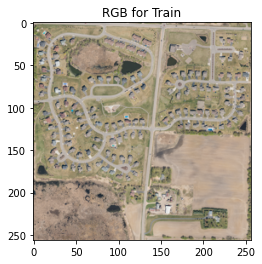

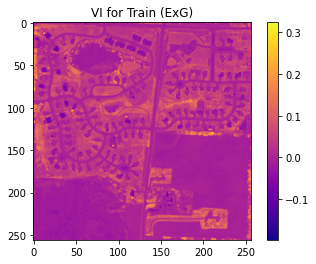

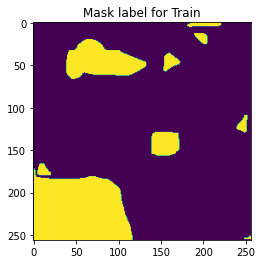

Sampling the Test data


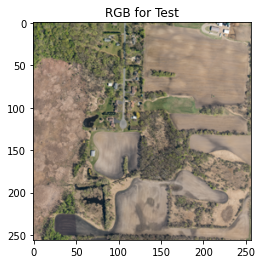

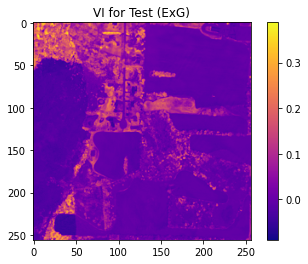

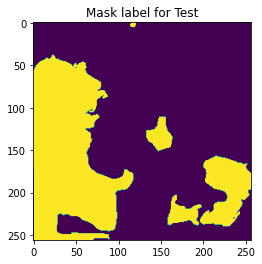

Sampling the Validation data


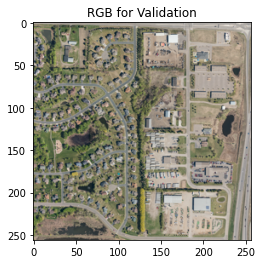

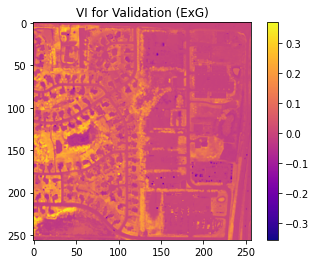

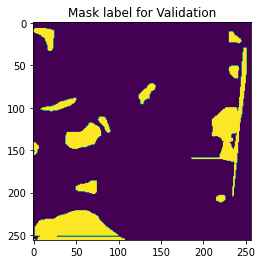

In [73]:
for (X, Y, Title) in [(X_train, Y_train, "Train"), (X_test, Y_test, "Test"), (X_val, Y_val, "Validation")]:
    print("Sampling the " + Title + " data")
    image_x = random.randint(0, len(X)-1)
    plt.imshow(X[image_x][:,:,:3])
    plt.title("RGB for "+Title)
    plt.figure()
    for c in range(IMG_CHANNELS-3):
        art = plt.imshow(X[image_x][:,:,3:4+c], cmap ='plasma')
        plt.colorbar(art)
        plt.title("VI for "+Title+" ("+IMG_INDEX+")")
        plt.figure()
    plt.imshow(np.squeeze(Y[image_x]))
    plt.title("Mask label for "+Title)
    plt.show()

In [74]:
#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

# Generate a UNetS model
unets_model = models.UNetS(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints'] + '/MPLS-UNetS.h5', verbose=1, save_best_only=True)]

# Check sample weighting
sample_weight = np.ones(shape=(len(Y_train),))

results = unets_model.fit(X_train, Y_train, sample_weight = sample_weight, validation_data=(X_val, Y_val), batch_size=8, epochs=10, callbacks=callbacks)

####################################

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 256, 256, 16) 592         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_65 (Dropout)            (None, 256, 256, 16) 0           conv2d_139[0][0]                 
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 256, 256, 16) 2320        dropout_65[0][0]                 
____________________________________________________________________________________________

In [75]:
# Generate a UNet model
unet_model = models.UNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

################################

#class CustomCallback(keras.callbacks.Callback):
#    def on_train_batch_begin(self, batch, logs=None):
#        if not hasattr(self.model.optimizer, "lr"):
#            raise ValueError('Optimizer must have a "lr" attribute.')
#        lr = float(tf.keras.backend.get_value(self.model.optimizer_learning_rate))
# sample_weights        

#Modelcheckpoint
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/Users/jayantgupta/SVANN/model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints'] + '/MPLS-UNet.h5', verbose=1, save_best_only=True)]

# Check sample weighting
#sample_weight = np.ones(shape=(len(Y_train),))

results = unet_model.fit(X_train, Y_train, sample_weight = sample_weight, validation_split=0.1, batch_size=16, epochs=3, callbacks=callbacks)

####################################

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 256, 256, 16) 592         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_70 (Dropout)            (None, 256, 256, 16) 0           conv2d_150[0][0]                 
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 256, 256, 16) 2320        dropout_70[0][0]                 
___________________________________________________________________________________________

1/1 [==============================] - 0s 181ms/step


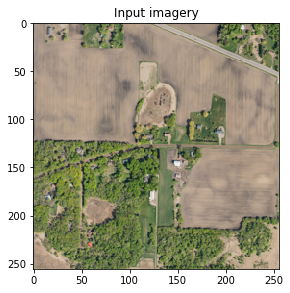

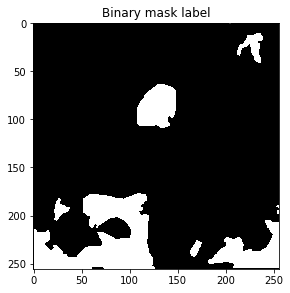

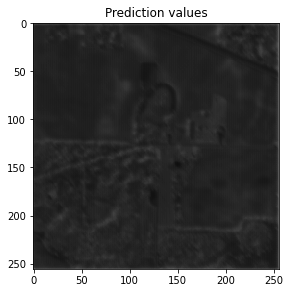

C:\Users\Carl\Desktop\spatial_computing\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


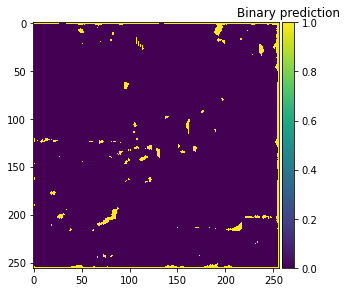

In [76]:
weight_file = json.load(open('config.json'))['filepaths']['default_checkpoints'] + '/MPLS-UNetS.h5'
unets_model.load_weights(weight_file)

preds_train = unets_model.predict(X_train, verbose=1)
preds_val = unets_model.predict(X_val, verbose=1)
preds_test = unets_model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.2).astype(np.uint8)
preds_val_t = (preds_val > 0.2).astype(np.uint8)
preds_test_t = (preds_test > 0.2).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t)-1)
imshow(X_train[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.title("Binary mask label")
plt.show()
imshow(np.squeeze(preds_train[ix]))
plt.title('Prediction values')
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.title('Binary prediction')
plt.show()


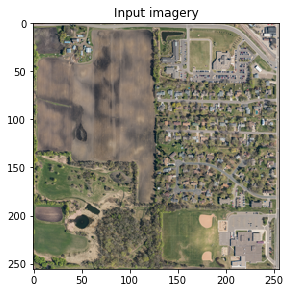

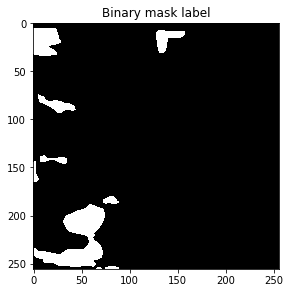

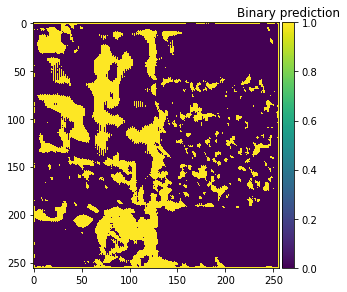

In [77]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(X_val)-1)
imshow(X_val[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.title("Binary mask label")
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title('Binary prediction')
plt.show()

In [78]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
for ix in range(0, len(preds_test_t)):
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_test[ix].astype(int).flatten(), preds_test_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_

print(tn, fp, fn, tp)

167573.0 15601.0 65855.0 13115.0


In [79]:
tn = 0.
fp = 0.
fn = 0.
tp = 0.
for ix in range(0, len(preds_val_t)):
    #print(ix)
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_val[ix].astype(int).flatten(), preds_val_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_
#    print(tn, fp, fn, tp)

print(tn, fp, fn, tp)

189184.0 23742.0 41545.0 7673.0


In [80]:
# # test images
# X_test = np.zeros((len(test_mask_pair), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((len(test_mask_pair), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# sizes_test = []
# print('Resizing test images') 
# n = 0
# for key, value in tqdm(test_mask_pair.items()):   
#     img_path = value[0]
#     img = imread(img_path)[:,:,:IMG_CHANNELS]  
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img  #Fill empty X_train with values from img
#     mask_path = value[1]
#     mask = imread(mask_path)
#     mask = mask.reshape(256, 256, 1)
#     mask_bool = mask > 0          
#     Y_test[n] = mask_bool 
#     n += 1

# print('Done!')

In [81]:
# Selecting test data samples
# Need to run once at the start
# print(img_mask_HCL_pair.keys)

# import shutil

# TEST_HCL_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/img'
# TEST_HCL_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/mask'

# TEST_HCR_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/img'
# TEST_HCR_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/mask'

# test_samples_HCL = random.choices(list(img_mask_HCL_pair.keys()), k=98)
# for sample in test_samples_HCL:
#     try:
#         img_path = img_mask_HCL_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCL_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
#     #print(img_path)
#     #print(img_test_path)

#         mask_path = img_mask_HCL_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCL_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)
#     except:
#         print(sample)
#     #break;

# test_samples_HCR = random.choices(list(img_mask_HCR_pair.keys()), k=98)
# for sample in test_samples_HCR:
#     try:
#         img_path = img_mask_HCR_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCR_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
    
#         mask_path = img_mask_HCR_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCR_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)    
#     except:
#         print(sample)